In [1]:
#Imports
from matplotlib.pyplot import figure, grid, legend, plot, show, xlabel
from numpy import array, concatenate, cos, dot, linspace, pi, reshape, sin, zeros
from numpy.linalg import inv, solve

from main import AffineDynamics, Controller, FBLinController, SystemDynamics, dcm_from_euler, elem_euler_rot, euler_to_ang, ss_cross


$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2}}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2}}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\R}{\bb{R}}$
$\newcommand{\grad}{\bs{\nabla}}$

# Quadrotor Simulation


Consider a quadrotor system specified as follows:

- A quadrotor frame with mass $m$ and fixed inertia tensor $\cal{J}$ specified about the center of mass.
- Four propellers mounted a distance $l$ away from the center of mass. 

We specify an inertial reference $\bs{\cal{F}}_i$ and a reference frame attached to the quadrotor body, $\bs{\cal{F}}_b$. The attitude of the quadrotor relative to the inertial frame is given by the direction cosine matrix (DCM) $\mb{C}_{bi}\in SO(3)$. We parameterize the attitude using the conventional "1-2-3" Euler-angle parameterization, such that:

\begin{equation}
\mb{C}_{bi}(\bs{\xi}) = \mb{C}_{bi}(\phi,\theta,\psi) = \mb{C}_3(\psi)\mb{C}_2(\theta)\mb{C}_1(\phi)
\end{equation}
where $\bs{\xi} = \begin{bmatrix}\phi & \theta & \psi \end{bmatrix}^\top$ and 
\begin{equation}
\mb{C}_1(\phi) = \begin{bmatrix}1 & 0 & 0 \\ 0 & \cos(\phi) & \sin(\phi) \\ 0 & -\sin(\phi) & \cos(\phi) \end{bmatrix}, \quad \mb{C}_2(\theta) = \begin{bmatrix}\cos(\theta) & 0 & -\sin(\theta) \\ 0 & 1 & 0 \\ \sin(\theta) & 0 & \cos(\theta) \end{bmatrix}, \quad \mb{C}_3(\psi) = \begin{bmatrix}\cos(\psi) & \sin(\psi) & 0 \\ -\sin(\psi) & \cos(\psi) & 0 \\ 0 & 0 & 1 \end{bmatrix} \in SO(3)
\end{equation}
The inertia tensor may be resolved in the body frame and expressed as $\mb{J}\in{S}^{3}_{++}$, and it assumed that the propellers generate thrust entirely along the vector $\underrightarrow{b}^3$.

The position of the quadrotor's center of mass relative to the origin of the inertial frame resolved in the inertial frame is given by

\begin{equation}
\mb{r}^{bi}_i = \begin{bmatrix}x \\ y \\ z \end{bmatrix}
\end{equation}

and the velocity of the quadrotor's center of mass relative to the origin of inertial frame with respect to the inertial frame resolved in the inertial frame is given by

\begin{equation}
\dot{\mb{r}}^{bi}_i = \begin{bmatrix}\dot{x} \\ \dot{y} \\ \dot{z} \end{bmatrix}
\end{equation}

We denote the angular velocity of the body frame relative to the inertial frame as $\underrightarrow{\omega}^{bi}$, and note that the resolution of this angular velocity in the body frame can be related to the Euler angle rates as follows:

\begin{equation}
\bs{\omega}^{bi}_b = \mb{T}(\bs{\xi})\dot{\bs{\xi}}
\end{equation}

To compute $\mb{T}(\bs{\xi})$, construct two intermediate reference frames, $\bs{\cal{F}}_p$ and $\bs{\cal{F}}_q$ such that

\begin{equation}
    \bs{\cal{F}}_i \overset{\mb{C}_1(\phi)}{\rightarrow} \bs{\cal{F}}_p \overset{\mb{C}_2(\theta)}{\rightarrow} \bs{\cal{F}}_q \overset{\mb{C}_3(\psi)}{\rightarrow} \bs{\cal{F}}_b
\end{equation}

We may express the angular velocities between these intermediate frames as:

\begin{equation}
\underrightarrow{\omega}^{pi} =  \underrightarrow{\bs{\cal{F}}_p}^\top \mb{e}_1\dot{\phi}, \quad \underrightarrow{\omega}^{qp} =  \underrightarrow{\bs{\cal{F}}_q}^\top \mb{e}_2\dot{\theta}, \quad \underrightarrow{\omega}^{bq} =  \underrightarrow{\bs{\cal{F}}_b}^\top \mb{e}_3\dot{\psi}  
\end{equation}
where $\mb{e}_i,\,i\in\{1,2,3\}$, are elementary basis vectors. Noting that physical angular velocity vectors add linearly such that:

\begin{equation}
\underrightarrow{\omega}^{bi} = \underrightarrow{\omega}^{bq}+\underrightarrow{\omega}^{qp}+\underrightarrow{\omega}^{pi}
\end{equation}

we get that 

\begin{align}
\bs{\omega}^{bi}_b & = \mathbf{C}_{bp}\mb{e}_1\dot{\phi} + \mb{C}_{bq} \mb{e}_2\dot{\theta} + \mb{e}_3\dot{\psi} \\ & = \mb{C}_{3}(\psi)\mb{C}_{2}(\theta)\mb{e}_1\dot{\phi} + \mb{C}_{3}(\psi) \mb{e}_2\dot{\theta} + \mb{e}_3\dot{\psi} \\ & = \begin{bmatrix}\mb{C}_3(\psi)\mb{C}_2(\theta)\mb{e}_1 &\mb{C}_3(\psi)\mb{e}_2 & \mb{e}_3 \end{bmatrix}\dot{\bs{\xi}}  \\ & = \mb{T}(\bs{\xi})\dot{\bs{\xi}}
\end{align}
We note that this matrix has a kinematic singularity that occurs when $\theta=\pm\frac{k\pi}{2},\,k=\{1,3,...\}$, and thus is non-invertible at these locations.

We now specify the state as follows:

\begin{equation}
\mb{x} = \begin{bmatrix}\mb{r}^{bi}_i \\ \dot{\mb{r}}^{bi}_i \\ \bs{\xi} \\ \bs{\omega}^{bi}_b \end{bmatrix} \in \R^{12}
\end{equation}

Utilizing the Newton-Euler equations, the state dynamics are given by: 

\begin{equation}
\dot{\mb{x}} = \begin{bmatrix} \dot{\mb{r}}^{bi}_i \\ \frac{1}{m}(\mb{f}^g_i+\mb{C}^\top_{bi}(\bs{\xi})\mathbf{f}^t_b) \\ \mb{T}^{-1}(\bs{\xi})\bs{\omega}^{bi}_b \\ \mb{J}^{-1}\bs{\tau}_b - \mb{J}^{-1}\bs{\omega}^{{bi}^\times}_b\mb{J}\bs{\omega}^{bi}_b \end{bmatrix}
\end{equation}

Here $\mb{f}^g_i=mg\mb{e}_3$ is the gravitational force in the inertial frame, $\mb{f}^t_b=f^t\mb{e}_3$ is the thrust generated by the quadrotor propellers in the body frame, $\bs{\tau}_b$ are the torques acting on the quadrotor resolved in the body frame, and $\bs{\omega}^{{bi}^\times}_b$ is the skew-symmetric cross operator applied to the angular velocity. The inputs to the system are considered to be $f^t$ and $\bs{\tau}_b$.



In [31]:
# System definition and dynamics
class QuadrotorSystem(SystemDynamics, AffineDynamics):
    def __init__(self, m, J, l, rot_order, g=9.81):
        SystemDynamics.__init__(self, 12, 1)
        self.params = m, J, l, g 
        self.f_gravity = -m * g * array([0, 0, 1])
        self.rot_order = rot_order
        self.dcm = dcm_from_euler(self.rot_order)
        self.T = euler_to_ang(self.rot_order)
                
    def drift(self, x, t):
        r, r_dot, xi, omega = reshape(x, (4, 3))
        m, J, _, _ = self.params
        return concatenate([r_dot, self.f_gravity / m, solve(self.T(xi), omega), solve(J, dot(ss_cross(omega), dot(J, omega)))])
    
    def act(self, x, t):
        _, _, xi, _ = reshape(x, (4, 3))
        return concatenate([zeros((3, 4)), concatenate([self.dcm(xi).T[:, 2:], zeros((3, 3))], 1) / m, zeros((3, 4)), concatenate([zeros((3, 1)), inv(J)], 1)])

In [40]:
# Elementary simulation
m, J, l, rot_order = 2, array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.4]]), 0.25, array([1, 2, 3])
system = QuadrotorSystem(m,J,l,rot_order)

controller = ConstantController(system, array([m*9.81, 0, 0, 0]))

x_0 = array([0, 0, 2, 0, 0, 0, pi/8, 0, 0, 0, 0, 0])
ts = linspace(0, 10, 1000)
xs, _ = system.simulate(x_0, controller, ts)


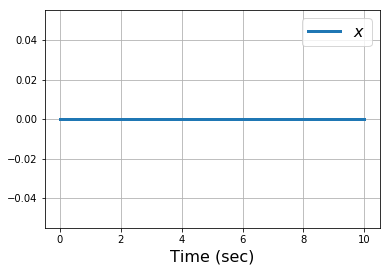

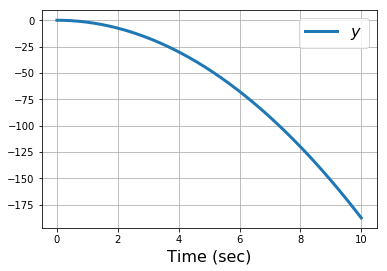

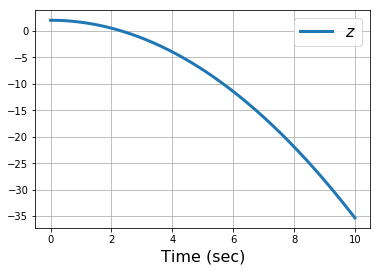

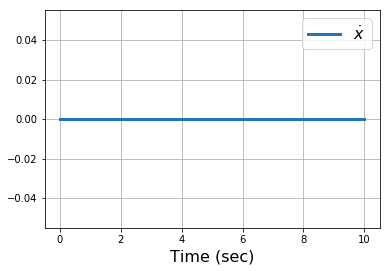

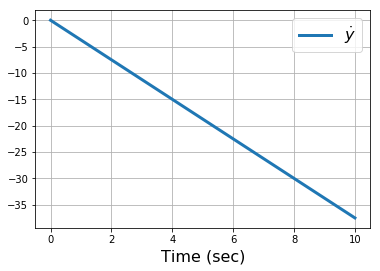

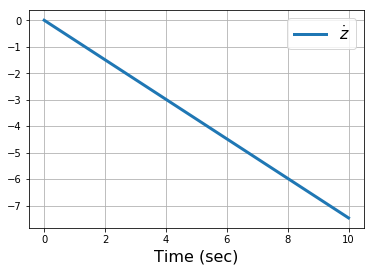

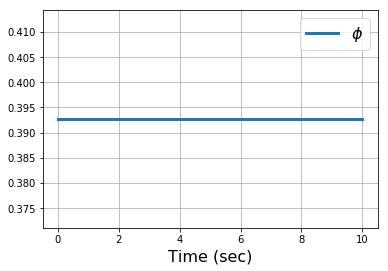

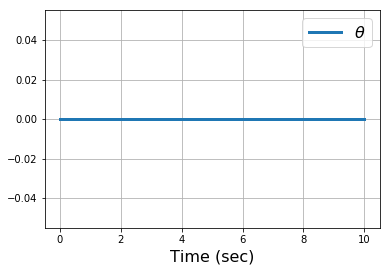

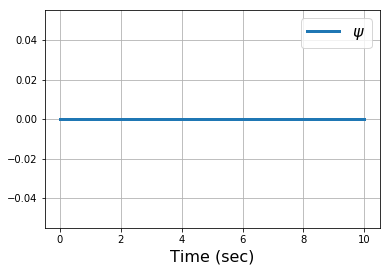

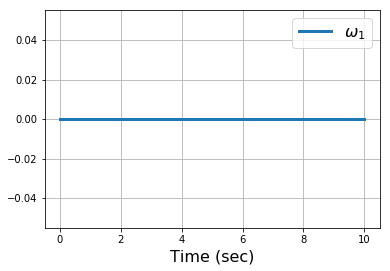

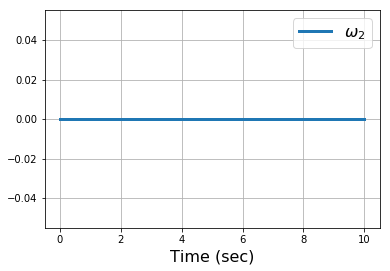

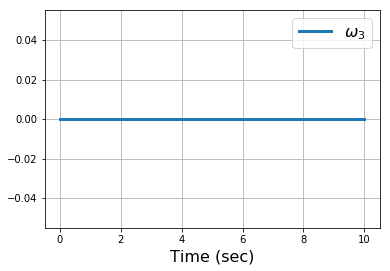

In [43]:
# Elementary simulation plotting

figure()
plot(ts, xs[:, 0], linewidth=3, label='$x$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3, label='$y$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3, label='$z$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 3], linewidth=3, label='$\\dot{x}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 4], linewidth=3, label='$\\dot{y}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 5], linewidth=3, label='$\\dot{z}$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 6], linewidth=3, label='$\\phi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 7], linewidth=3, label='$\\theta$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 8], linewidth=3, label='$\\psi$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 9], linewidth=3, label='$\\omega_1$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 10], linewidth=3, label='$\\omega_2$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 11], linewidth=3, label='$\\omega_3$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

show()

# Dynamic Extension

The quadrotor presents an interesting control problem as it is not possible to achieve position tracking without using the quadrotors attitude to steer the vehicle. We will take a feedback linearization approach to solving the problem of positioning tracking, and will employ a tool known as dynamic extension to get the proper relative degree for the system.

Assuming position tracking is our control objective, we choose the following output:

\begin{equation}
\mb{y} = \mb{h}(\mb{x}) = \begin{bmatrix}\mb{r}^{bi}_i \\ \psi \end{bmatrix}
\end{equation}

Taking the time derivative of output yields:

\begin{equation}
\dot{\mb{y}} = \begin{bmatrix}\dot{\mb{r}}^{bi}_i \\ \dot{\psi} \end{bmatrix} = \begin{bmatrix}\dot{\mb{r}}^{bi}_i \\ \mb{e}^\top_3\mb{T}^{-1}(\bs{\xi})\bs{\omega}^{bi}_b \end{bmatrix}
\end{equation}

To simplify our notation and analysis, we will view $\mb{T},\mb{T}^{-1}:\R^3\to\R^{3\times 3}$ and as multilinear operators, such that $\mb{T}(\bs{\xi})(\cdot,\cdot),\mb{T}^{-1}(\bs{\xi})(\cdot,\cdot):\R^3\times\R^3\to\R$. To demonstrate this notation we rewrite the the preceding equation as:

\begin{equation}
\dot{\mb{y}} = \begin{bmatrix}\dot{\mb{r}}^{bi}_i \\ \mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\bs{\omega}^{bi}_b) \end{bmatrix}
\end{equation}

Taking a further time derivative results in:

\begin{equation}
\ddot{\mb{y}} = \begin{bmatrix}\ddot{\mb{r}}^{bi}_i \\ \grad\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\bs{\omega}^{bi}_b,\dot{\bs{\xi}})+\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\dot{\bs{\omega}}^{bi}_b) \end{bmatrix} = \begin{bmatrix}\frac{1}{m}(\mb{f}^g_i+\mb{C}^\top_{bi}(\bs{\xi})\mathbf{f}^t_b)\\ \grad\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\bs{\omega}^{bi}_b,\dot{\bs{\xi}})+\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\dot{\bs{\omega}}^{bi}_b) \end{bmatrix}
\end{equation}

To avoid the computation of $\grad\mb{T}^{-1}(\bs{\xi})$ and utilize the more readily computable $\grad\mb{T}(\bs{\xi})$, we utilize the following steps:

\begin{equation}
\bs{\omega}^{bi}_b = \mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}})
\end{equation}
\begin{equation}
\dot{\bs{\omega}}^{bi}_b = \grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})+\mb{T}(\bs{\xi})(\cdot,\ddot{\bs{\xi}})
\end{equation}
\begin{equation}
\ddot{\bs{\xi}} = \mb{T}^{-1}(\bs{\xi})(\cdot,\dot{\bs{\omega}}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))
\end{equation}
\begin{equation}
\ddot{\psi}=\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\dot{\bs{\omega}}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))
\end{equation}

Using the expression for $\dot{\bs{\omega}}^{bi}_b$, this can be further expressed as:

\begin{equation}
\ddot{\psi} = -\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))+\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\cdot)\mb{J}^{-1}\bs{\tau}_b
\end{equation}

From this we conclude that $\ddot{\psi}$ has relative degree $\gamma_\psi=2$.

We can then write the $\ddot{\mb{y}}$ dynamics as 

\begin{equation}
\ddot{\mb{y}} = \begin{bmatrix}\frac{1}{m}\mb{f}^g_i\\ -\mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\mb{J}^{-1}\bs{\omega}^{bi^\times}_b\mb{J}\bs{\omega}^{bi}_b-\grad\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})) \end{bmatrix} + \begin{bmatrix} \frac{1}{m}\mb{C}^\top_{bi}(\bs{\xi})\mb{e}_3 & \mb{0}_{3\times 3}\\ 0 & \mb{T}^{-1}(\bs{\xi})(\mb{e}_3,\cdot)\mb{J}^{-1} \end{bmatrix} \begin{bmatrix}f^t \\ \bs{\tau}_b \end{bmatrix}
\end{equation}
